### Preprocessing of ECG Signals

In [2]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

### 1. Preprocessing - Denoising the signal

This function denoise uses wavelet transform to remove noise from the input signal data. It applies a symmetric 4 (sym4) wavelet and performs a multi-level discrete wavelet decomposition to break the signal into approximation and detail coefficients. The function then thresholds the detail coefficients to filter out noise based on a predefined threshold. Finally, it reconstructs the signal by applying the inverse wavelet transform, returning a cleaner version of the input data.

In [4]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec


### 2. Preprocessing - Reading Raw ECG Signals for 48 contiguous ECG excerpts

| **Label** | **Description**                                                                                                                                                        |
|-----------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **N**     | Normal heartbeat or cardiac complex. The electrical activity of the heart is within the normal range, with no abnormalities or irregularities in the heart rhythm.      |
| **L**     | Left bundle branch block. An abnormality in the electrical conduction system where signals do not travel normally through the left bundle branch, affecting ventricular contractions. |
| **R**     | Right bundle branch block. An abnormality in the electrical conduction system involving the right bundle branch, similar to left bundle branch block.                     |
| **A**     | Atrial premature beat. An early contraction originating in the atria (upper chambers of the heart) before the next expected normal heartbeat.                           |
| **V**     | Ventricular premature beat. An early contraction originating in the ventricles (lower chambers of the heart) before the next expected normal heartbeat.                 |


In [5]:
path = '/input/mitbit-arrhythmia-database/mitbih_database/'
window_size = 1000
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [6]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

In [7]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

In [9]:
len(records)

48

### 3. Preprocessing - Segmentation into windows of 2000 sample points

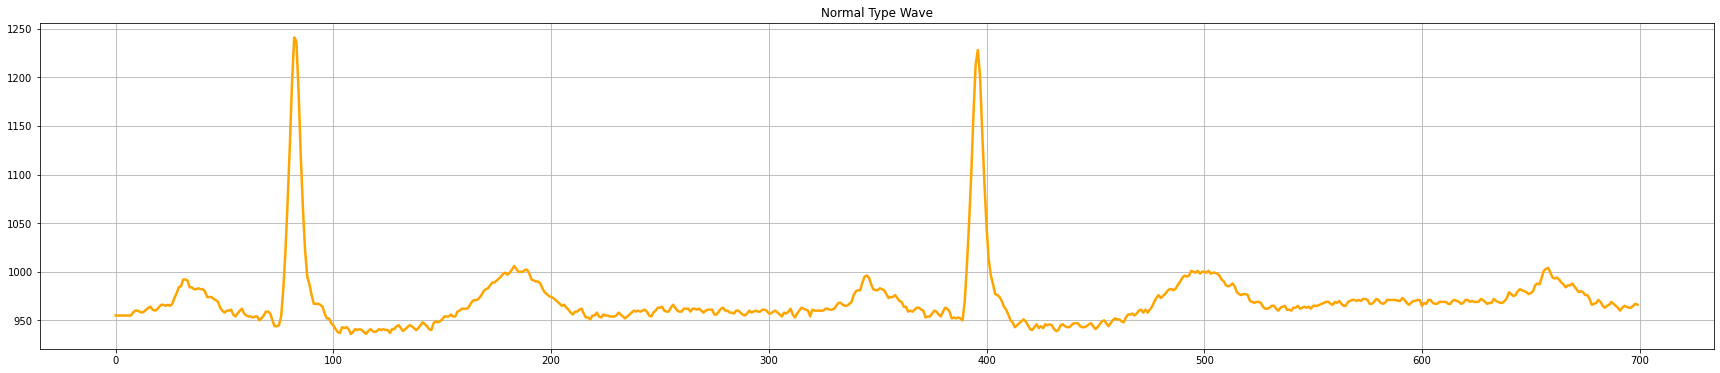

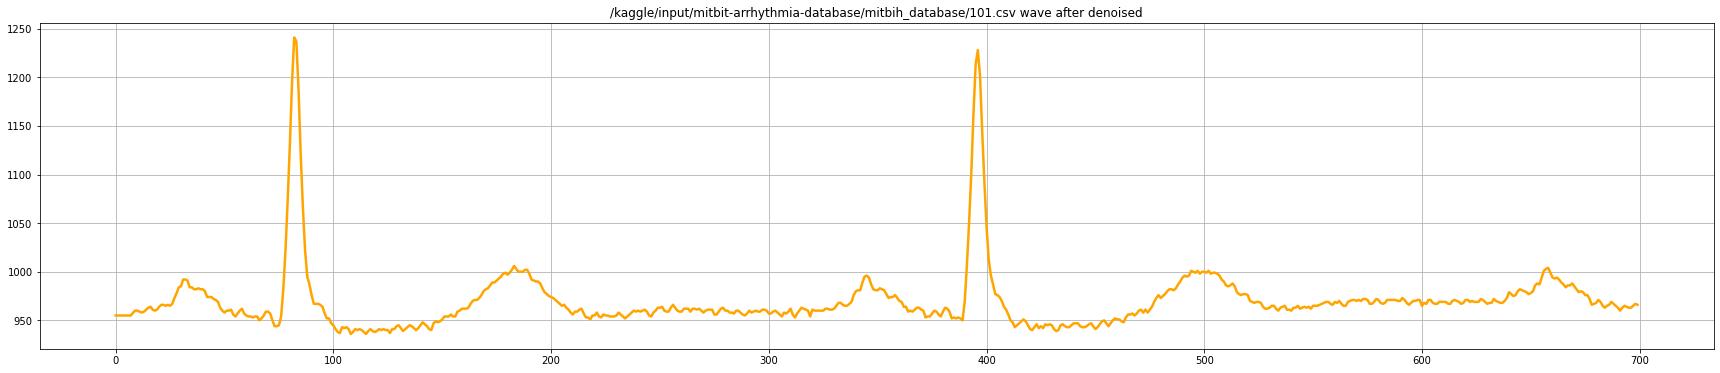

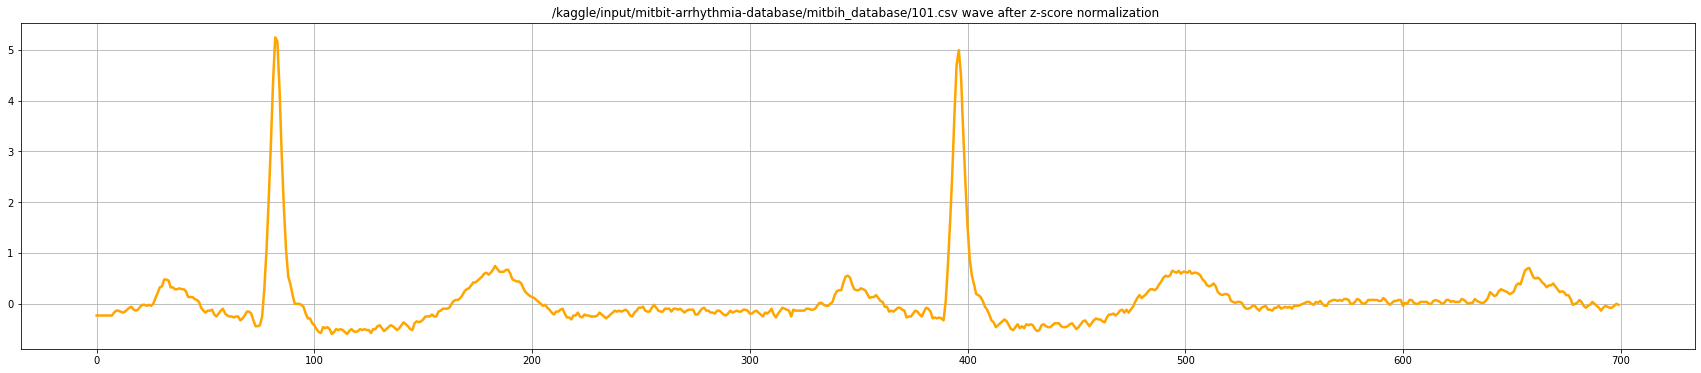

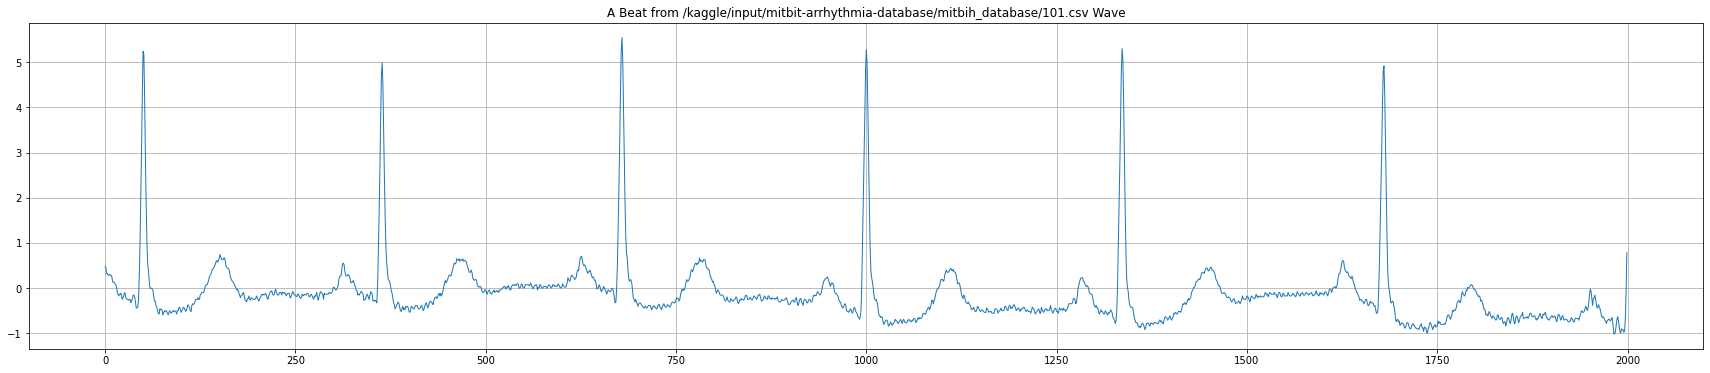

(99754, 2000) (99754,)


In [13]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title("Normal Type Wave")
        plt.plot(signals[0:700], color='orange', linewidth=2.5) 
        plt.show()
        
    
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700], color='orange', linewidth=2.5) 
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700], color='orange', linewidth=2.5) 
        plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))


In [14]:
print(np.shape(X), np.shape(y))

(99754, 2000) (99754,)


In [19]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))


(99754, 2001)


### 4. Preprocessing - Distribution of the classes is unbalanced

0.0    74815
1.0     8053
2.0     7235
4.0     7114
3.0     2537
Name: 2000, dtype: int64


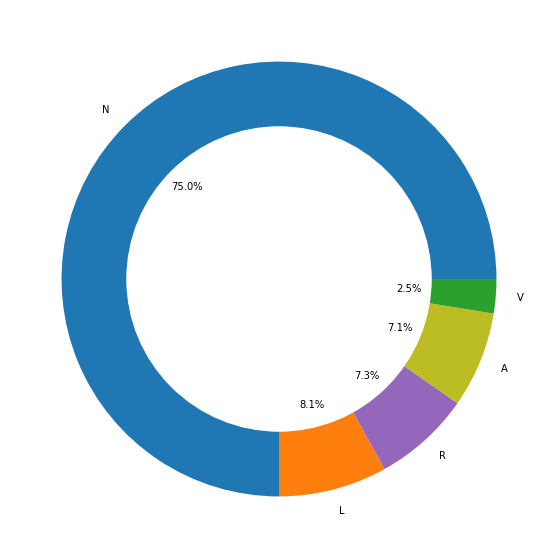

In [20]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

### 5. Preprocessing - Balancing the classes with each class having 3000 segments

In [22]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=3000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=3000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=3000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=3000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=3000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

4.0    3000
3.0    3000
2.0    3000
1.0    3000
0.0    3000
Name: 2000, dtype: int64


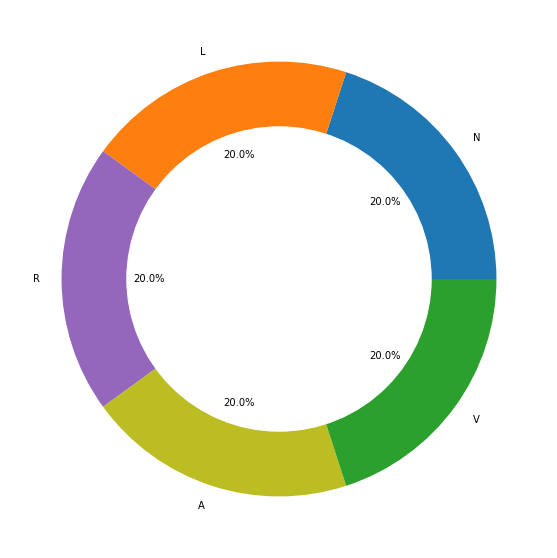

In [23]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [27]:
X_train_df.shape

(15000, 2001)

In [28]:
data_df = X_train_df.iloc[:, :-1]  # First 2000 columns
labels_df = X_train_df.iloc[:, -1]

In [54]:
resampled_data_df = data_df.reset_index(drop=True)

In [116]:
labels_df = labels_df.reset_index(drop=True)